# Data Preparation for Flood Filling Unet Training

In this file a dataset is created to train a flood filling 3D Unet with. This task encompasses the following steps:

- Open Tiff Stacks / h5 or n5 files
- data exploration and visualization
- sample mining
- creation of training examples

For FFUnet training one trainig scene should allow the network to do at least one step in each direction.

In [1]:
import numpy as np 
import os, sys, random
import matplotlib.pyplot as plt
from importlib import reload
from scipy.stats import linregress

import h5py, z5py
from tqdm import tqdm

sys.path.append('../tools/')
import tilingStrategy, Dataset3D, visualization

In [2]:
reload(visualization)
reload(Dataset3D)
reload(tilingStrategy)

<module 'tilingStrategy' from '../tools\\tilingStrategy.py'>

## Open the file and load the potentially large image volume

In [3]:
# Open an image volume
image_path = "C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\large_image_0724.h5"
image_h5 = h5py.File(image_path, mode='r+') # Open h5 file with read / write access
print(image_h5['t0'].keys()) # Show Groups (Folders) in root Group of the h5 archive

image = image_h5['t0/channel0']

mask_path = "C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\large_mask_0724.h5"
mask_h5 = h5py.File(mask_path, mode='r') # Open h5 file with read / write access

mask = mask_h5['t0/channel0']
print('loaded image with shape {}\nloaded mask with shape {}'.format(image.shape, mask.shape))

<KeysViewHDF5 ['channel0', 'unet']>
loaded image with shape (500, 2000, 2000)
loaded mask with shape (500, 2000, 2000)


## Sample Mining - Tiling method

One training example should allow the ffunet to make a step into each direction. Therefore we need to cut out cubes of (input_size + 2*step_size) length.
For the FFUnet to move along the structure contained in the image, it needs to be present at the center of it's current field of view +/- the step size it can take.
Each training scene is guaranteed to satisfy this condiction for the CENTRAL TILE ONLY.

To mine samples where we need to find cubes of scene size, where an object is present within a smaller, centered cube of +/- stepsize size

In [4]:
# Define geometry of example subvolumes
input_shape = (220,220,220)
delta = (8,8,8)
example_shape = tuple([i+2*d for i,d in zip(input_shape,delta)])
fov_shape = tuple([d*2 for d in delta])

# Use the fov_shape shape to tile the volume, choose the example shape as input shape so that Dataset 3D stores large enough areas around the choosen locations
tiler = tilingStrategy.UnetTiler3D(image=image, mask=mask, output_shape=fov_shape, input_shape=example_shape)
print(tiler.shape)
# since input = ouput shape there is no padding

[32, 125, 125]


In [12]:
indices = Dataset3D.getRandomIndices(tiler, n_samples=2000) # sample random tiles from the image volume

100%|██████████| 2000/2000 [00:22<00:00, 89.92it/s]


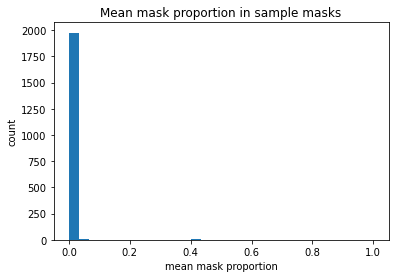

In [13]:
mask_proportions = Dataset3D.sampleMaskProportion(tiler, indices)
# Plot the distribution of the mean signal strength in our samples
_ = plt.hist(mask_proportions, bins=30)
plt.title('Mean mask proportion in sample masks')
plt.xlabel('mean mask proportion')
plt.ylabel('count')
plt.show()

In [15]:
print('{} elements contain mask'.format(np.count_nonzero([s > 0 for s in mask_proportions])))

29 elements contain mask


In [16]:
# Prepare a detaset with mask thresholded sampling
#mask_thresholded = Dataset3D.thresholdedSampling(indices, mask_proportions, threshold=0, above_threshold_ratio=1, n_samples=50)
mask_thresholded = [indices[i] for i in range(len(indices)) if mask_proportions[i]>0]

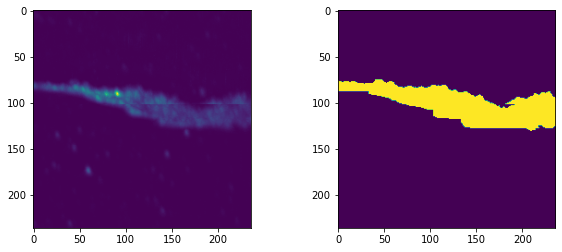

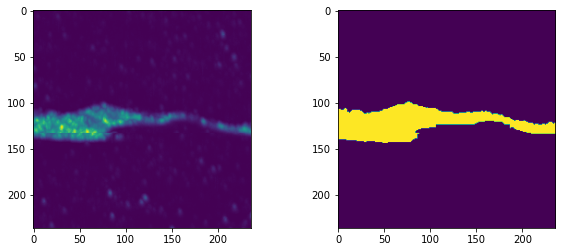

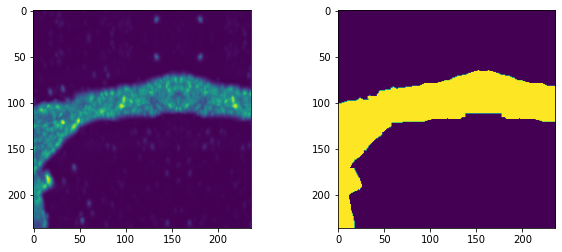

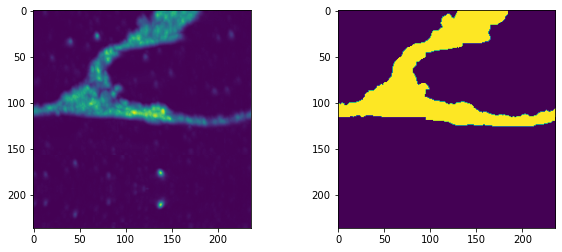

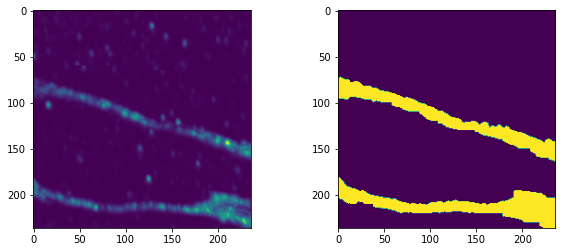

In [17]:
for index in mask_thresholded[:5]:
    visualization.showProjections([tiler.getSlice(index),tiler.getMaskSlice(index,cropped=False)])

## Sample Mining - Mask Skeletonization method

Random sampling of a regular grid becomes very inefficient if the tiles become smaller.
Instead, sample training scenes by sampling random points from the mask skeleton and centering the training scene around them.


In [5]:
# Use skimage method to skeletonize the mask
from skimage.morphology import skeletonize_3d
mask_skeleton = skeletonize_3d(mask) # zero->bg nonzero->object

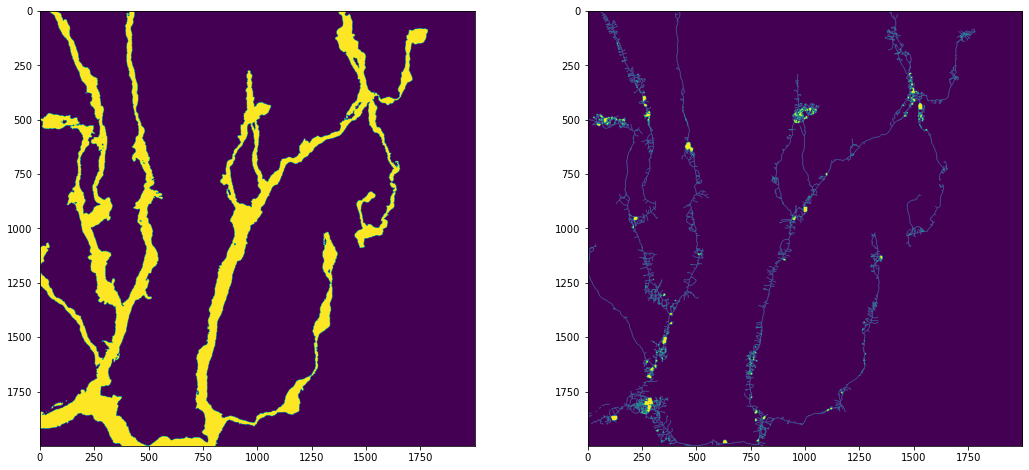

In [6]:
# Show a z projection of the mask and it's skeleton
visualization.showProjections([np.clip(mask,0,1),mask_skeleton],axis=0,mode='max',size=8)

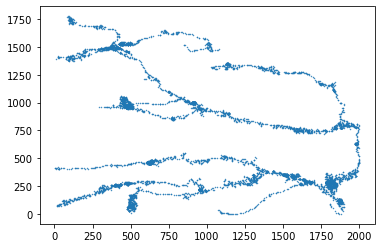

In [7]:
# Convert the (quite sparse) skeleton to a list of coordinates
skeleton_cords = np.nonzero(mask_skeleton)# ([x0,x1,..],[y0,...],[z0,...])
# Display a z Projection of the mask skeleton
plt.scatter(skeleton_cords[1][::10],skeleton_cords[2][::10],
s=0.2)

In [8]:
def getCoords(index):
    return [skeleton_cords[0][index],
               skeleton_cords[1][index],
               skeleton_cords[2][index]]
# Sample centerpoints from the mask skeleton
# naive approach
def sample_random_skeleton_pixel_coordinates(n_samples = 50):
    n_pixels = len(skeleton_cords[0]) # get the number of skeleton pixels
    # sample random pixels coordinates from list
    indices = np.random.choice(n_pixels, size=n_samples, replace=False) 
    coords = [getCoords(index) for index in indices]
    return np.array(coords)

sample_centerpoints = sample_random_skeleton_pixel_coordinates(n_samples=50)

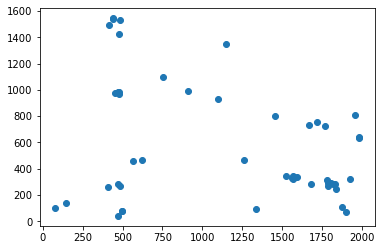

In [9]:
# Visualize the distribution of sampled centerpoint
plt.scatter(sample_centerpoints[:,1],sample_centerpoints[:,2])

In [10]:
def shortestDistance(points, point):
    dist = [np.sum(
        [(a-b)**2 for a,b in zip(point,p)]
    ) for p in points ]
    return np.min(dist)

# use distance weighted probabilities
def sampleDistributedCenterpoints(n_samples):
    n_pixels = len(skeleton_cords[0]) # get the number of skeleton pixels
    # subsample skeleton pixels
    subsample = random.choices(np.arange(n_pixels), k=n_samples*10)
    samples = []
    # randomly sample first point
    index = random.choice(subsample)
    subsample.remove(index)
    samples.append(getCoords(index))

    for n in range(n_samples-1):
        # get the distances to all remaining points
        distances = [shortestDistance(samples, getCoords(p)) for p in subsample]
        # Normalize sum to get a probability distribution
        distances /= np.sum(distances)
        # Sample next point weighted by distance
        index = np.random.choice(subsample, p=distances)
        subsample.remove(index)
        samples.append(getCoords(index))
    
    return np.array(samples)

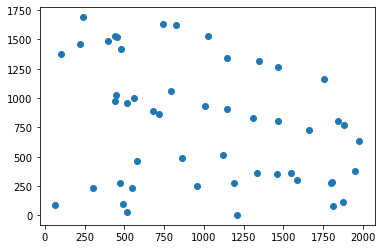

In [11]:
dist_cp = sampleDistributedCenterpoints(n_samples=50)
# Visualize the distribution of sampled centerpoint
plt.scatter(dist_cp[:,1],dist_cp[:,2])

In [12]:
def getCenteredAABB(centerpoint: tuple, shape:tuple, image_shape)->tuple:
    delta = [d//2 for d in shape] # the aabb extends half it's shape in each direction from the centerpoint
    corner1 = [c-d for c,d in zip(centerpoint,delta)]
    corner2 = [c+d for c,d in zip(centerpoint,delta)]
    aabb = tuple(np.concatenate((corner1,corner2)))
    is_contained = np.all([c>=0 for c in corner1]) and np.all([c<=d for c,d in zip(corner2,image_shape)])
    return aabb, is_contained

In [13]:
# Use a canvas to read aabb from the image and mask tensors
image_canvas = tilingStrategy.Canvas(image)
mask_canvas  = tilingStrategy.Canvas( mask)

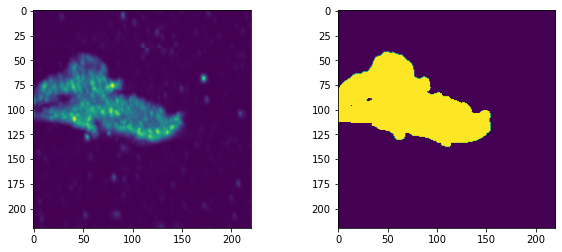

AABB (29, 1867, 524, 249, 2087, 744) around [ 139 1977  634] protrudes from image volume


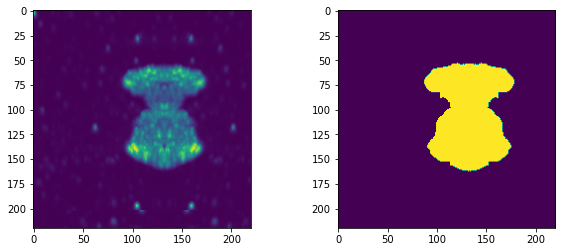

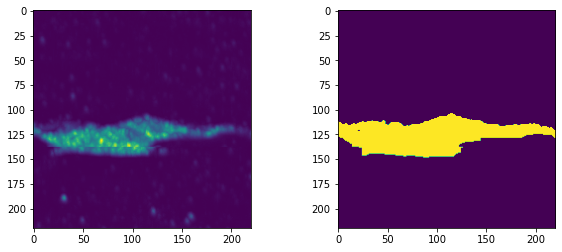

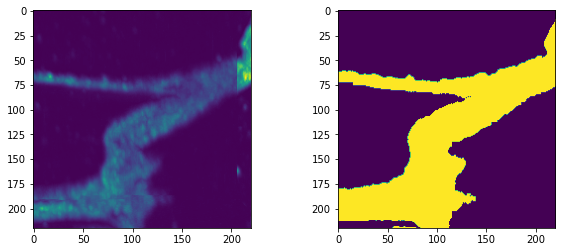

AABB (-41, 1843, 263, 179, 2063, 483) around [  69 1953  373] protrudes from image volume


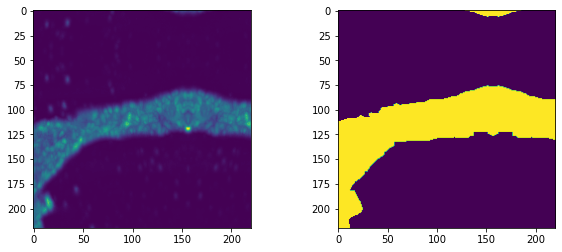

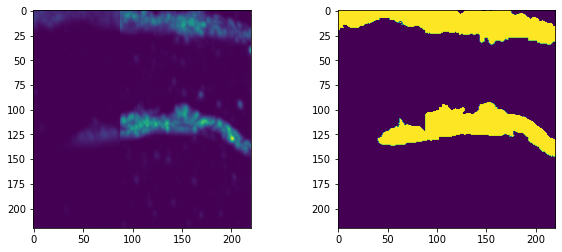

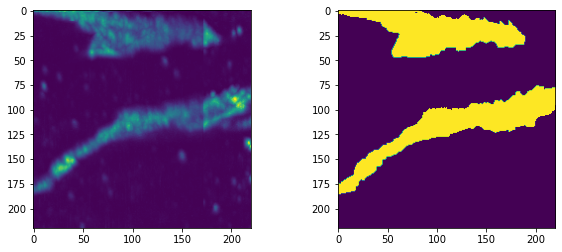

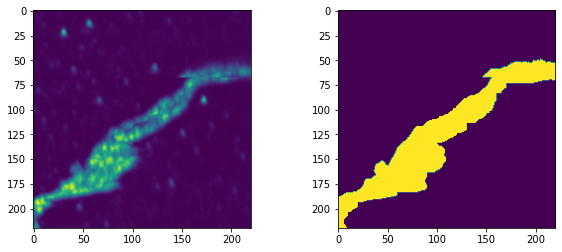

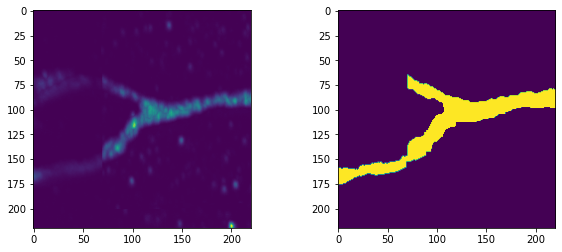

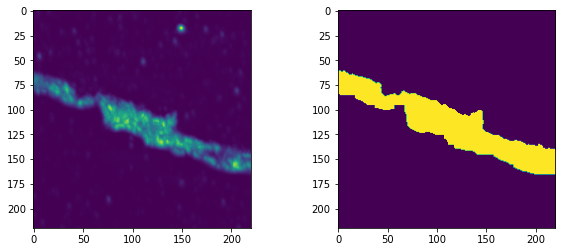

In [14]:
for centerpoint in dist_cp[::5]:
    aabb, contained = getCenteredAABB(centerpoint, shape=(220,220,220), image_shape=image.shape)
    if not contained:
        print('AABB {} around {} protrudes from image volume'.format(aabb,centerpoint))
    sample_image = image_canvas.cropAndPadAABB(aabb)
    sample_mask  = np.clip(mask_canvas.cropAndPadAABB(aabb),0,1)
    visualization.showProjections([sample_image, sample_mask])

## Create a dataset

Use the Dataset3D class to create a new dataset or append to an existing one.
Datasets contain named entries that hold an input image and it's corresponding mask together with some metadata.

In [19]:
reload(Dataset3D)
dataset = Dataset3D.Dataset(dataset_path='C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\ffn_dataset.h5')
dataset.keys()

<KeysViewHDF5 []>

In [20]:
for i,cp in tqdm(enumerate(dist_cp)):
    key = 'a_' + str(i) # use a_index as naming scheme
    # Extract the cubes defines in example_shape around the centerpoints
    aabb, contained = getCenteredAABB(cp, shape=example_shape, image_shape=image.shape)
    # Only include scenes that are fully included in the image
    if contained:
        sample_image = image_canvas.cropAndPadAABB(aabb)
        sample_mask = mask_canvas.cropAndPadAABB(aabb)
        dataset.add(key, sample_image, sample_mask, metadata={'centerpoint':cp, 'source_image': image_path, 'date': 20200826})

50it [00:11,  4.37it/s]


In [21]:
dataset.setAttribute('stepsize', delta)
dataset.setAttribute('input_shape', input_shape)
dataset.setAttribute('comment','This dataset is intended for flood filling network training. Each training example allows for a grid of 3x3x3 evaluations. Each example is guaranteed to contain the object at the central pixel of the example')

In [22]:
# Close the dataset
print(dataset.keys())
dataset.close()

<KeysViewHDF5 ['a_1', 'a_10', 'a_12', 'a_13', 'a_14', 'a_15', 'a_16', 'a_17', 'a_18', 'a_2', 'a_21', 'a_22', 'a_24', 'a_25', 'a_26', 'a_27', 'a_28', 'a_30', 'a_31', 'a_33', 'a_35', 'a_36', 'a_37', 'a_40', 'a_41', 'a_42', 'a_44', 'a_45', 'a_46', 'a_47', 'a_48', 'a_49', 'a_6', 'a_7', 'a_8']>


## Inspect a prepared dataset

In [23]:
# Open the dataset
reload(Dataset3D)
dataset = Dataset3D.Dataset('C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\ffn_dataset.h5')

Opened dataset with 35 preexisting items. Overwriting items with the same name.


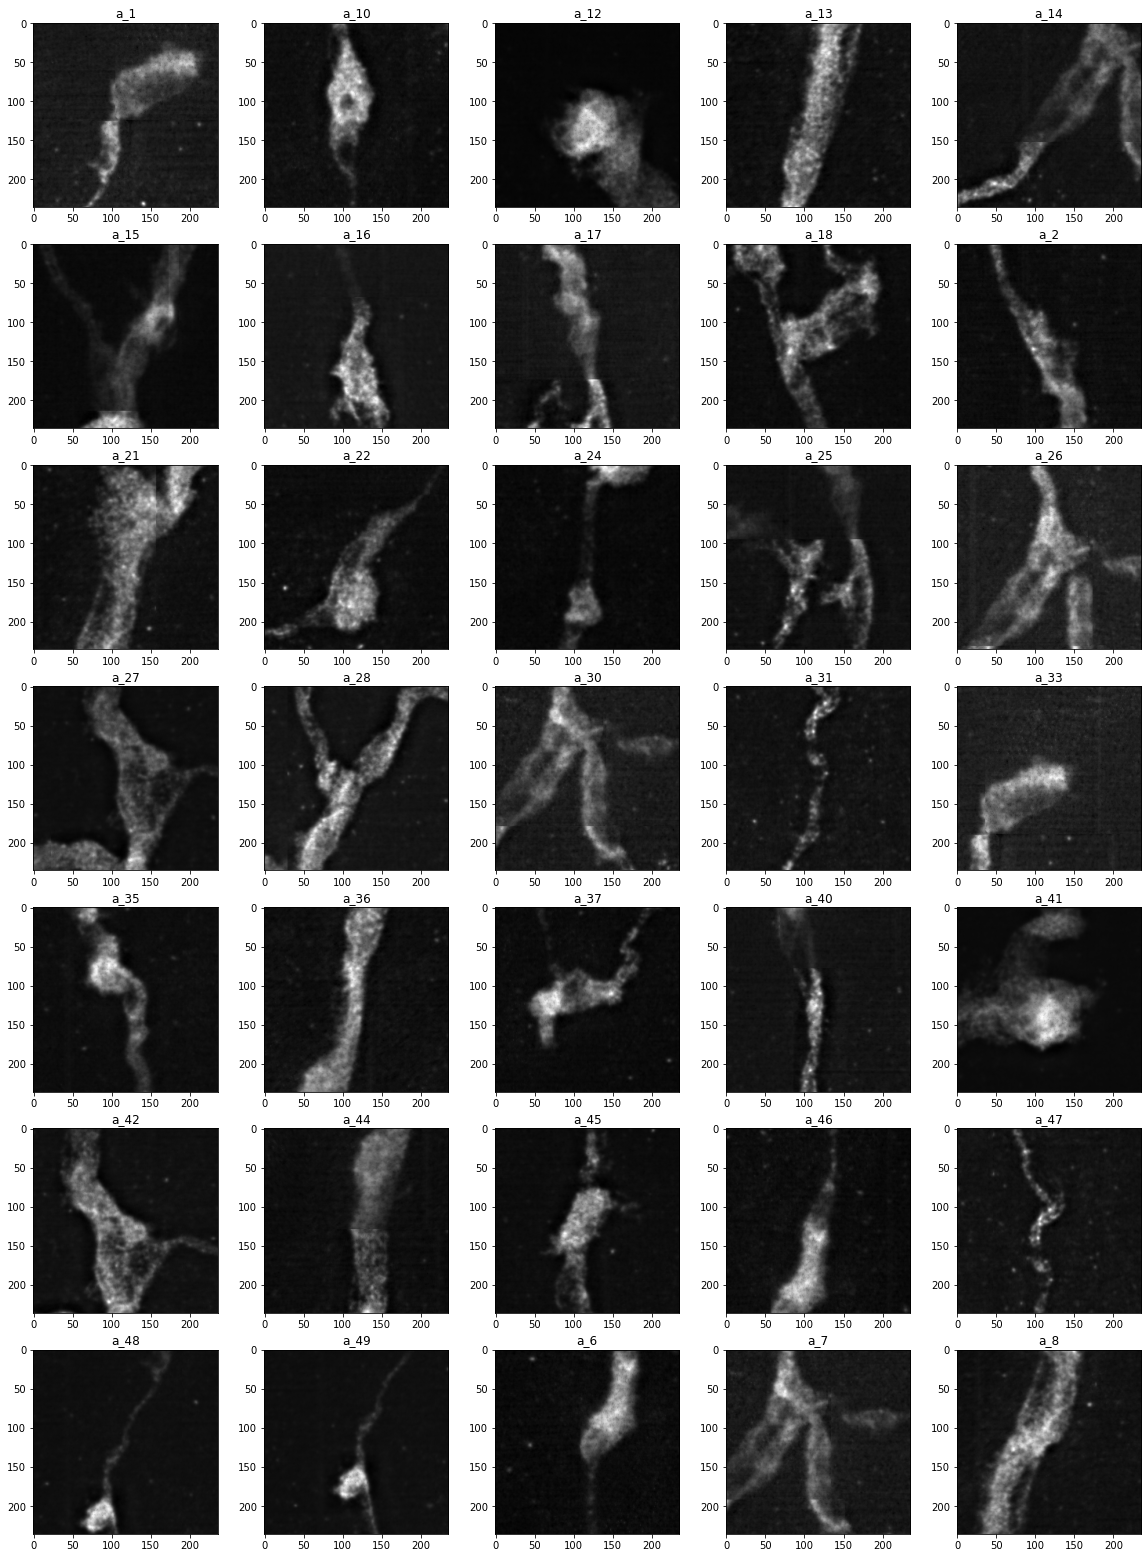

In [24]:
# Visualize the content of a generated dataset
plt.figure(figsize=(20,40))
samples = list(dataset.keys())
for i, sample in enumerate(samples):
    plt.subplot(10,5,i+1)
    plt.gca().set_title(sample)
    plt.imshow(np.sum(dataset.get(sample)[0], axis=0), cmap='gray')

In [18]:
bad_entries = [244,242]
[dataset.delete(entry) for entry in bad_entries]

[None, None]

In [25]:
dataset.close()